In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio

## analysis imports
from analysis.quarterly_analysis import QuarterlyAnalysis as quarterly_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class
from fund.fund import Fund

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
backtest_start_date = datetime(2003,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [3]:
market = Market()

In [4]:
portfolio = APortfolio(pricer_list.WEEKLY_STOCK_SPECULATION
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_ii = APortfolio(pricer_list.WEEKLY_STOCK_ROLLING
                           ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_iii = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_iv = APortfolio(pricer_list.WEEKLY_CRYPTO_ROLLING
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_v = APortfolio(pricer_list.WEEKLY_CRYPTO_WINDOW
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_vi = APortfolio(pricer_list.WEEKLY_CRYPTO_SPECULATION
                          ,classifier_list.NONE
                          ,ranker_list.NONE)

portfolios = []
portfolios.append(portfolio)
portfolios.append(portfolio_ii)
portfolios.append(portfolio_iii)
portfolios.append(portfolio_iv)
portfolios.append(portfolio_v)
portfolios.append(portfolio_vi)

In [5]:
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
market = Market()
fund.initialize_portfolios()

In [6]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [7]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields"))
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()

In [8]:
trades = []
for portfolio in fund.portfolios:
    portfolio.db.connect()
    try:
        trade = portfolio.db.retrieve("trades")
        trade["positions"] = int(portfolio.pricer_class.positions / 5) if portfolio.pricer_class.asset_class.value == "stocks" else 1
        trade["portfolio"] = portfolio.name
        trade = trade[trade["position"] <= int(portfolio.pricer_class.positions / 5)]
        trade["pricer_timeframe"] = portfolio.pricer_class.time_horizon_class.naming_convention
        trades.append(trade)
    except Exception as e:
        print(str(e))
        continue
    portfolio.db.disconnect()

In [9]:
t = pd.concat(trades)
t = t[(t["year"]>=backtest_start_date.year) & (t["year"]<backtest_end_date.year)]

In [10]:
nonindex_columns = [
"year"
,"quarter"
,"week"
,"ticker"
,"quarterly_delta_sign"
,"quarterly_delta"
,"weekly_delta_sign"
,"weekly_delta"
,"short_returns"
,"returns"
,"floored_returns"
,"actual_returns"
,"position"
,"projected_quarterly_return"
,"positions"] 

In [11]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [12]:
indexer

['value',
 'ceiling',
 'classification',
 'rank',
 'short',
 'market_return',
 'buy_day',
 'sell_day',
 'risk',
 'floor_value',
 'portfolio',
 'pricer_timeframe']

In [13]:
analysis = []
for parameter in tqdm(parameters):
    try:
        ledger = t.sort_values(["year",parameter["pricer_timeframe"]]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(int(ledger["positions"].mean()))
        anas = weekly_analysis if parameter["pricer_timeframe"] == "week" else quarterly_analysis
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:54<00:00,  1.21s/it]


In [14]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,floor_value,portfolio,pricer_timeframe,pv,beta,rrr,sharpe
317,True,True,False,False,False,1.15,1,15,none,1.0,wsr_n_n_b_r,week,234.368559,-0.134639,0.823938,-1733.286957
317,True,True,False,False,False,1.15,1,15,flat,1.0,wsr_n_n_b_r,week,222.015960,-0.123864,0.838056,-1784.340518
317,True,True,False,False,False,1.15,1,15,none,0.5,wsr_n_n_b_r,week,187.616264,-0.156404,0.795420,-1193.164094
317,True,True,False,False,False,1.15,1,15,flat,0.5,wsr_n_n_b_r,week,177.221326,-0.141908,0.814414,-1241.799767
317,True,True,False,False,False,1.15,1,15,rrr,1.0,wsr_n_n_b_r,week,68.991867,-0.095505,0.875213,-711.916326
317,True,True,False,False,False,1.15,1,15,rrr,0.5,wsr_n_n_b_r,week,55.782667,-0.095629,0.875050,-572.861417
317,True,True,False,False,False,1.15,1,15,none,1.0,wsw_n_n_b_r,week,54.021564,-0.058580,0.923594,-905.115475
234,True,True,False,False,False,1.15,1,20,none,0.5,wsw_n_n_b_r,week,50.758915,0.195732,1.274340,254.217475
317,True,True,False,False,False,1.15,1,15,none,0.5,wsw_n_n_b_r,week,50.096145,-0.059426,0.922485,-826.166787
956,True,True,False,False,False,1.15,1,5,none,1.0,wsw_n_n_b_r,week,47.418402,-0.022801,0.971877,-2035.773245


In [15]:
a.sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,floor_value,pricer_timeframe,pv,beta,rrr,sharpe
0,wcr_n_n_b_r,True,True,False,False,False,1.15,1,5,none,1.0,week,2.023391,-0.071745,0.973993,-14.259487
1,wcs_n_n_b_r,True,True,False,False,False,1.15,1,5,flat,0.5,week,1.391982,0.039061,1.005340,10.026299
2,wcw_n_n_b_r,True,True,False,False,False,1.15,1,5,none,0.5,week,1.993192,-0.033786,0.983746,-29.385847
3,wsr_n_n_b_r,True,True,False,False,False,1.15,1,15,none,1.0,week,234.368559,-0.134639,0.823938,-1733.286957
4,wss_n_n_b_r,True,True,False,False,False,1.15,1,15,none,1.0,week,41.425365,-0.071096,0.907195,-568.598830
5,wsw_n_n_b_r,True,True,False,False,False,1.15,1,15,none,1.0,week,54.021564,-0.058580,0.923594,-905.115475


In [16]:
top = a.sort_values("pv",ascending=False).iloc[0]
anas = weekly_analysis if top["pricer_timeframe"] == "week" else quarterly_analysis
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
naming = top["pricer_timeframe"]
positions = int(int(analysis["positions"].mean()))
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[ledger["year"]>=backtest_start_date.year]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

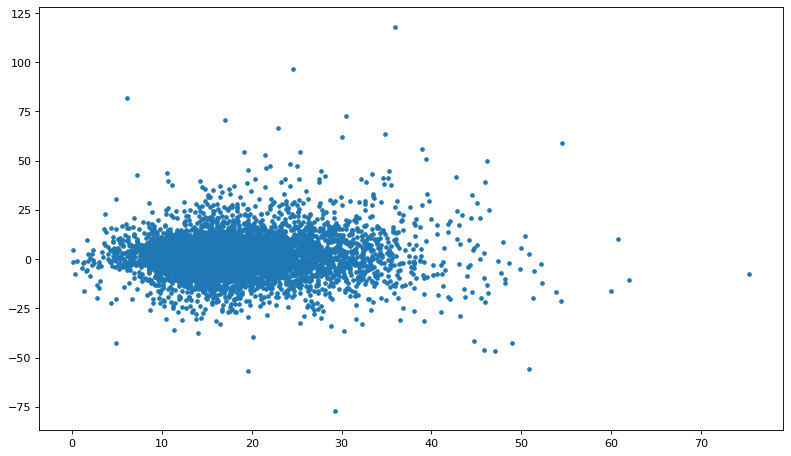

In [17]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [18]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2003,6,AMT,0.440700,1.0,0.959184,0,Real Estate,American Tower
318,2003,6,SEE,0.304796,1.0,0.959883,1,Materials,Sealed Air
636,2003,6,GLW,0.265659,1.0,1.179104,2,Information Technology,Corning Inc.
954,2003,6,AES,0.263400,1.0,1.006079,3,Utilities,AES Corporation
1272,2003,6,TRMB,0.247665,1.0,1.000600,4,Information Technology,Trimble Inc.
1590,2003,6,ODFL,0.207662,1.0,0.863124,5,Industrials,Old Dominion
1908,2003,6,DISH,0.205638,1.0,1.034198,6,Communication Services,Dish Network
2226,2003,6,NFLX,0.202168,1.0,1.182927,7,Communication Services,Netflix
2544,2003,6,JNPR,0.201495,1.0,0.984901,8,Information Technology,Juniper Networks
2862,2003,6,ALGN,0.195579,1.0,1.453125,9,Health Care,Align Technology


In [19]:
ledger["actual_returns"].mean()

1.0154062007270503

In [20]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5681477033923746

In [21]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [22]:
positions

20

In [23]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [24]:
cumulative.head(50)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,week,pv,adjclose,bench,date_string,date
0,0.959184,0.959883,1.179104,1.006079,1.000600,0.863124,1.034198,1.182927,0.984901,1.453125,...,1.008883,1.005538,1.011298,2003,6,1.033779,854.137988,1.000000,2003-W6,2003-02-07
1,1.170153,1.023875,1.424438,1.247205,1.117453,1.104681,1.074827,1.234199,1.069858,2.012019,...,1.023067,1.087550,1.050278,2003,9,1.144823,845.392487,0.989761,2003-W9,2003-02-28
2,1.409308,1.101963,1.539595,1.195239,1.305907,1.235606,1.585370,1.223114,1.059471,2.049090,...,1.057439,1.166916,1.046353,2003,12,1.210910,815.514001,0.954780,2003-W12,2003-03-21
3,1.994529,1.255570,2.174834,1.578766,1.377256,1.396027,1.711684,1.536826,0.998667,2.080460,...,1.113767,1.301859,1.010737,2003,15,1.366997,868.571997,1.016899,2003-W15,2003-04-11
4,3.167782,1.345769,2.679512,2.172434,1.530500,1.331736,2.030905,1.496183,1.540232,2.853397,...,1.054366,1.292586,0.960832,2003,18,1.566810,906.528003,1.061337,2003-W18,2003-05-02
5,3.496293,1.732135,2.882836,2.556832,2.311837,1.838099,2.125422,1.913929,1.671716,3.261943,...,1.148667,1.974131,1.030774,2003,21,1.851227,943.531995,1.104660,2003-W21,2003-05-23
6,3.404285,1.698693,2.672629,2.314539,2.414051,1.504989,1.963258,1.729285,2.162616,3.331770,...,1.095398,2.390776,0.966497,2003,24,1.797310,980.540003,1.147988,2003-W24,2003-06-13
7,3.594681,2.025806,2.520961,2.353548,5.264014,1.757322,2.218355,1.853824,1.810882,3.199320,...,1.068610,2.548204,1.023655,2003,27,1.984022,980.490002,1.147929,2003-W27,2003-07-04
8,3.692622,2.013675,1.991707,2.332073,5.903840,1.760732,1.601074,1.403031,1.742639,4.311376,...,0.910984,2.486111,1.114540,2003,30,1.982906,994.683996,1.164547,2003-W30,2003-07-25
9,4.902319,1.977284,2.340333,2.551685,5.960365,1.881813,1.628936,1.514062,1.888433,5.120334,...,0.940872,2.544462,1.178155,2003,33,2.164549,973.414014,1.139645,2003-W33,2003-08-15


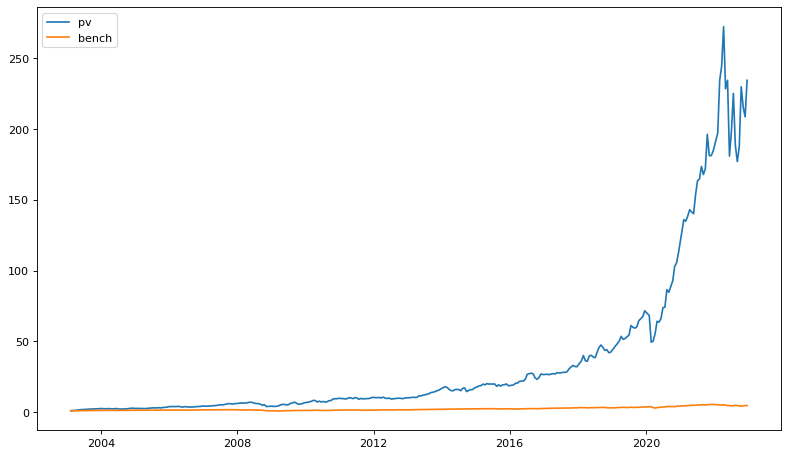

In [25]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [26]:
cumulative.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,week,pv,adjclose,bench,date_string,date
298,133.904912,28.962686,135.210148,48.045481,94.644029,20.873773,3001.545738,10.164914,15.338656,21.094195,...,59.653190,3.002305,8.144017,2021,42,196.233394,4397.05,5.147939,2021-W42,2021-10-22
299,143.259285,24.368805,138.659094,48.106779,87.866837,20.417395,2742.830752,10.057486,13.526061,19.229154,...,59.428999,2.974357,7.439815,2021,45,181.154441,4656.50,5.451695,2021-W45,2021-11-12
300,127.487873,22.196123,141.404716,36.368725,72.037512,20.451353,2802.861441,10.041627,11.072868,21.375887,...,60.222959,2.842627,8.422130,2021,48,181.142352,4667.43,5.464492,2021-W48,2021-12-03
301,122.513791,21.413924,141.839871,35.004560,89.890766,19.793381,2847.256976,10.575987,11.494621,21.160851,...,63.204530,2.680629,8.781612,2021,51,184.396030,4660.44,5.456308,2021-W51,2021-12-24
302,127.501771,23.410646,143.902333,43.028477,94.089913,22.804239,3071.478313,12.117243,11.595088,23.596109,...,69.455360,2.572033,8.522482,2022,6,197.127042,4525.89,5.298781,2022-W6,2022-02-11
303,132.696388,29.705589,183.837117,46.355712,108.682494,23.833165,3729.785443,13.166819,11.188278,24.766667,...,75.249185,2.516769,9.405935,2022,9,234.310157,4300.90,5.035369,2022-W9,2022-03-04
304,131.583910,34.137909,201.889922,49.405266,108.028139,25.389183,3882.585143,13.520801,11.523743,24.408135,...,80.934523,2.631589,9.055052,2022,12,244.338772,4333.64,5.073700,2022-W12,2022-03-25
305,117.009964,35.540600,187.569010,47.593031,97.677425,24.342317,4484.748507,14.251655,11.325133,26.233200,...,73.980622,2.552159,8.632657,2022,15,272.223254,4515.48,5.286593,2022-W15,2022-04-15
306,120.692639,39.038265,137.251234,50.017568,83.809909,25.716026,3661.247762,14.620348,12.148831,26.192961,...,72.808222,2.385347,8.871910,2022,18,228.395201,4214.94,4.934730,2022-W18,2022-05-06
307,112.031087,40.323721,129.125624,49.480349,83.780062,26.138900,3829.957254,12.482030,12.211891,26.147554,...,68.228912,2.096953,7.872048,2022,21,234.340715,3964.54,4.641569,2022-W21,2022-05-27


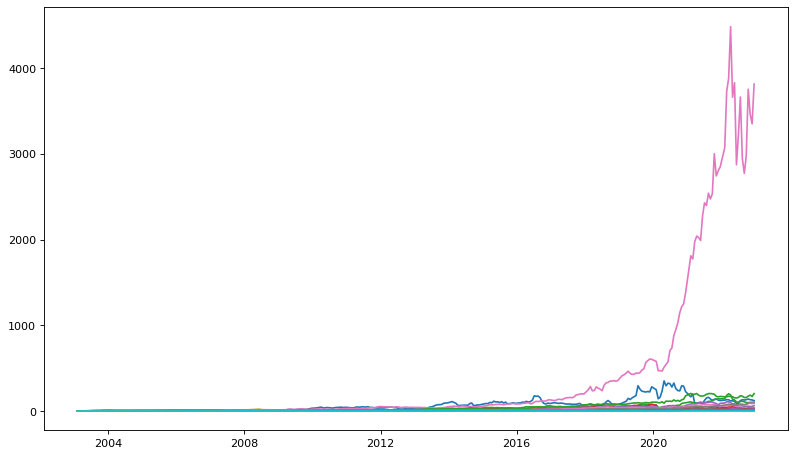

In [27]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [28]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Real Estate,2009.198157,26.364055,0.191959,1.0,1.030573,11.525346
Materials,2012.587467,27.838120,0.185848,1.0,1.025043,10.070496
Information Technology,2012.873280,29.000724,0.194194,1.0,1.019497,9.499638
Consumer Discretionary,2012.403146,30.104305,0.184575,1.0,1.018067,10.039735
Consumer Staples,2012.587302,27.797619,0.150186,1.0,1.015193,9.785714
Financials,2011.683824,31.492647,0.190775,1.0,1.013685,10.982843
Health Care,2012.632948,28.326590,0.183291,1.0,1.013654,9.585742
Energy,2014.435798,24.601167,0.177755,1.0,1.009974,9.768482
Communication Services,2012.811736,27.124694,0.188273,1.0,1.009719,8.916870


In [29]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

,,,,weekly_delta,weekly_delta_sign,actual_returns,position
year,week,ticker,Security,,,,
2003,27,EQIX,Equinix,0.359140,1.0,2.180573,4
2017,45,ENPH,Enphase,0.246270,1.0,1.965753,1
2008,42,AAL,American Airlines Group,0.061201,1.0,1.817690,5
2020,33,TSLA,"Tesla, Inc.",0.304913,1.0,1.728221,9
2018,9,ENPH,Enphase,0.169813,1.0,1.706093,11
2003,21,PWR,Quanta Services,0.228799,1.0,1.666667,14
2019,30,ENPH,Enphase,0.348794,1.0,1.637150,0
2013,18,TSLA,"Tesla, Inc.",0.300716,1.0,1.622337,2
2003,18,SBAC,SBA Communications,0.545718,1.0,1.588235,0


In [30]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2003,6,1.108562,1.134942,1.000000,1.144615,1.000000,1.100789,0.962721,1.037427,0.927754,0.959184,1.005808
1,4012009,54,1.338147,1.231475,1.000000,1.201731,1.000000,1.229585,0.966423,1.118326,1.007781,1.169996,1.049404
2,8036054027,648,1.383166,1.250510,1.000000,1.404398,1.000000,1.295804,0.984229,1.098709,1.041639,1.368774,1.049404
3,16096216216081,9720,1.476670,1.381123,1.000000,1.983854,1.053276,1.476431,0.975013,1.195644,1.041639,1.619517,1.386136
4,32240721080810243,174960,1.408665,1.551378,1.000000,2.126373,1.063645,1.553312,0.923012,1.266471,1.041639,2.238309,1.707793
...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,0,0,5.407678,55.907884,14.395417,6.326101,8.391181,23.669076,5.387059,152.566729,36.475700,10.132887,1.279750
314,0,0,5.915083,62.793630,14.420049,7.224428,8.877301,25.347180,5.387059,152.566729,36.475700,10.132887,1.294987
315,0,0,5.915083,64.516339,14.420049,6.887569,8.844984,26.125228,5.529180,152.566729,36.475700,10.132887,1.424046
316,0,0,5.646850,61.726341,14.420049,6.599643,8.691101,26.450108,5.455147,152.566729,36.645212,10.132887,1.424046
